# CDC Diabetes Health Indicators

### Importing Data

In [303]:
# From UCI Repository
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets  

In [304]:
# Import libraries
import pandas as pd # Analysis
import numpy as np # Numerical Python
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold #  Grid Search/Train Test Split/Cross Validation
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay # Confusion Matrix and Info
from sklearn.compose import ColumnTransformer # Multiple Transforms on multiple columns
from sklearn.preprocessing import OneHotEncoder # Standard Scalar, One Hot Encode features 
import matplotlib.pyplot as plt # plotting
import seaborn as sns # Plotting
pd.set_option('display.max_columns', None) # to display all columns

### Sources

The following are sources used in this analysis. I gathered my data from the UCI Data Repository. You will also find
links to the codebook for category breakdowns and clarifcation of BMI categories.

https://www.cdc.gov/brfss/annual_data/2014/pdf/CODEBOOK14_LLCP.pdf

https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators

https://www.cdc.gov/healthyweight/assessing/index.html

### Summary & EDA

In [307]:
# Missing Data
pd.DataFrame(X.isnull().value_counts())

,,,,,,,,,,,,,,,,,,,,,count
HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,
False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,253680


In the above dataframe, there are no missing data. 

In [308]:
# What are the dimensions of my data 
print(X.shape)
print(y.shape)

(253680, 21)
(253680, 1)


There were 253,680 rows of data and 21 initial features. 

In [309]:
# Class Imbalance
y.value_counts()/len(y)*100

Diabetes_binary
0                  86.066698
1                  13.933302
Name: count, dtype: float64

We can see that we have a heavy class imbalance with only 13% of cases identified as diabetes. There are a multitude of ways to help class imbalance: class weighting, stratefication, up and down sampling etc..
For this analysis I have chosen stratefication of target during train/test split and class weighting. I will also be checking for sparsity of data/low variance/no variance. 

In [310]:
# Do all columns that are binary have at least 0, 1?
print(X.describe().loc[['min','max']])

     HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  \
min     0.0       0.0        0.0  12.0     0.0     0.0                   0.0   
max     1.0       1.0        1.0  98.0     1.0     1.0                   1.0   

     PhysActivity  Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  \
min           0.0     0.0      0.0                0.0            0.0   
max           1.0     1.0      1.0                1.0            1.0   

     NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
min          0.0      1.0       0.0       0.0       0.0  0.0   1.0        1.0   
max          1.0      5.0      30.0      30.0       1.0  1.0  13.0        6.0   

     Income  
min     1.0  
max     8.0  


In [311]:
# Sparsity - are there two few cases in columns? 
for x in X.columns:
    print(X[x].value_counts(normalize=True)*100, X[x].value_counts())

HighBP
0    57.09989
1    42.90011
Name: proportion, dtype: float64 HighBP
0    144851
1    108829
Name: count, dtype: int64
HighChol
0    57.587906
1    42.412094
Name: proportion, dtype: float64 HighChol
0    146089
1    107591
Name: count, dtype: int64
CholCheck
1    96.26695
0     3.73305
Name: proportion, dtype: float64 CholCheck
1    244210
0      9470
Name: count, dtype: int64
BMI
27    9.699622
26    8.105487
24    7.706559
25    6.758909
28    6.521996
        ...   
85    0.000394
91    0.000394
86    0.000394
90    0.000394
78    0.000394
Name: proportion, Length: 84, dtype: float64 BMI
27    24606
26    20562
24    19550
25    17146
28    16545
      ...  
85        1
91        1
86        1
90        1
78        1
Name: count, Length: 84, dtype: int64
Smoker
0    55.683144
1    44.316856
Name: proportion, dtype: float64 Smoker
0    141257
1    112423
Name: count, dtype: int64
Stroke
0    95.94292
1     4.05708
Name: proportion, dtype: float64 Stroke
0    243388
1     10292

### Off the Cuff Visualizations

In [312]:
# We need full data set with target
FullDF = cdc_diabetes_health_indicators.data.original

In [314]:
# Plot A few Variables Against the Target 
# Combine y and x data for plotting
subset = FullDF[['Income', 'Age', 'Education','Diabetes_binary']]
m = subset.melt(id_vars=['Diabetes_binary'], var_name='feature')

C:\Users\avales\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

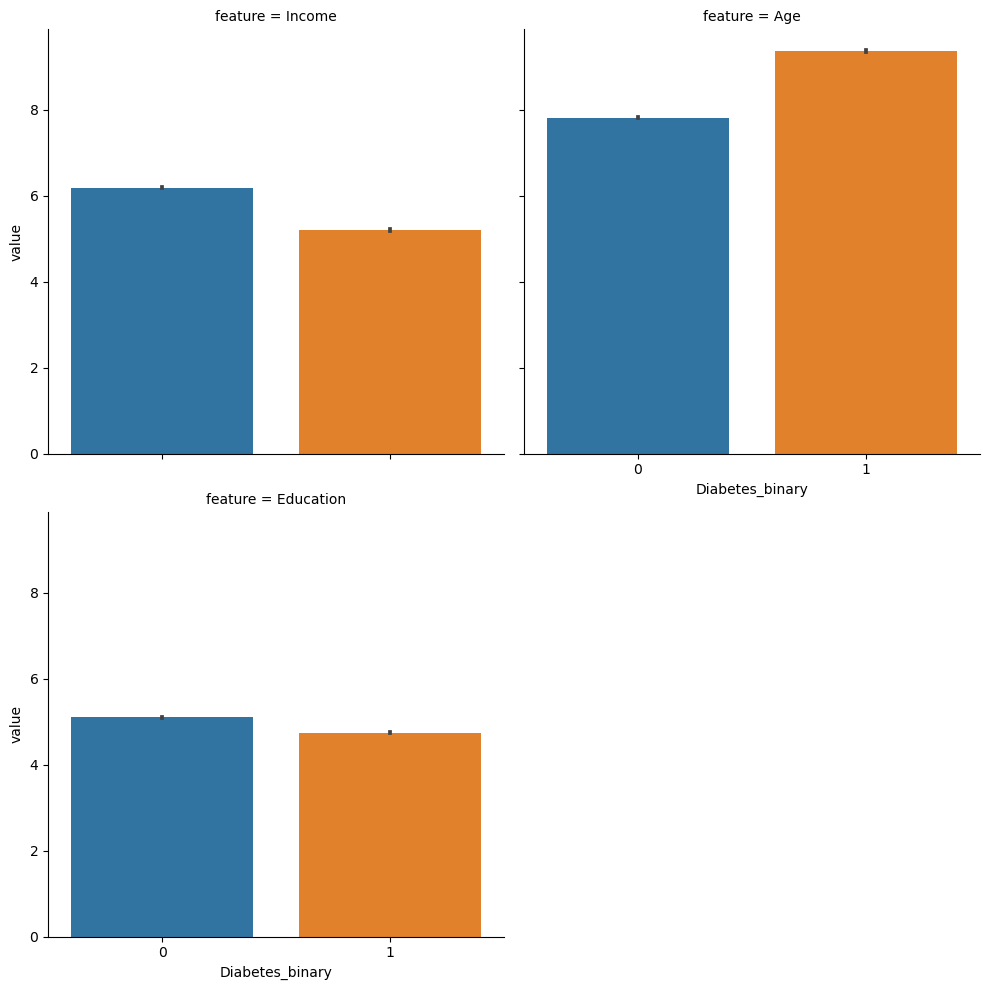

<Figure size 1500x800 with 0 Axes>

In [316]:
sns.catplot(data=m, x='Diabetes_binary', y='value', col='feature', kind='bar', col_wrap=2)
plt.figure(figsize=(15,8))

The following bar plots show that these variables might not be indicative or being able to predict diabetes. We cannot see clear distinctions, albeit I have left categories as numeric. 

<Axes: xlabel='Diabetes_binary', ylabel='BMI'>

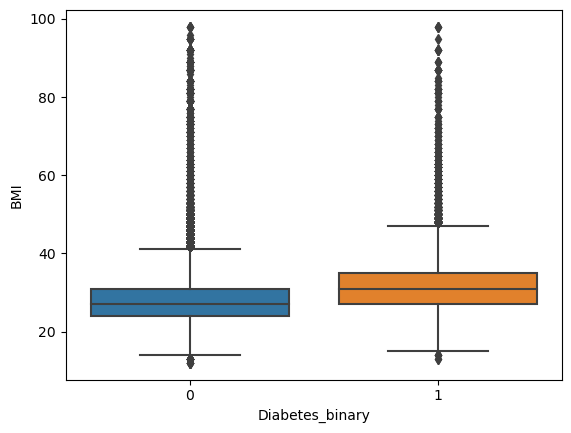

In [317]:
# Box Plot of BMI and Diabetes
sns.boxplot(x='Diabetes_binary', y='BMI', data=FullDF)

<Axes: xlabel='Diabetes_binary', ylabel='Age'>

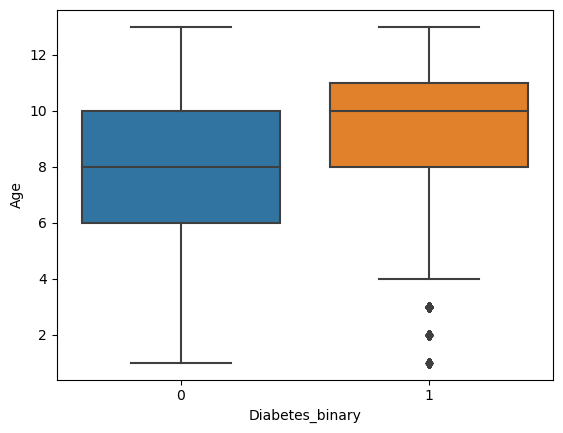

In [318]:
# Box Plot of Age and Diabetes
sns.boxplot(x='Diabetes_binary', y='Age', data=FullDF)

<Axes: xlabel='Diabetes_binary', ylabel='MentHlth'>

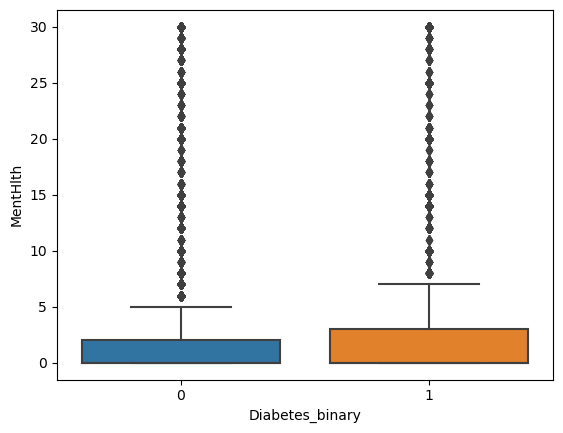

In [319]:
# Box Plot of Menthlth and Diabetes
sns.boxplot(x='Diabetes_binary', y='MentHlth', data=FullDF)

The above box plots do show some outliers, however, I have chosen a model that is insensitive to outliers (Random Forest) as well as the need for scaling. Again, I don't see clear distinctions that pop out and show a variable is extremely predictive for diabetes. Below, I will be manipulating variables into different bins due to lower variance (BMI and Education). 

### Further Data Manipulation

In [320]:
# Reclassify BMI as Healthy Weight, Unhealthy Weight (undeweight, overweigth, obese)
bins = [0, 18, 25, np.inf]
names = ['Unhealthy', 'Healthy', 'Unhealthy']

X['BMIRange'] = pd.cut(X['BMI'], bins, labels=names, ordered= False)

C:\Users\avales\AppData\Local\Temp\ipykernel_28796\4160622568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['BMIRange'] = pd.cut(X['BMI'], bins, labels=names, ordered= False)


In [368]:
# Perform Data Checks
#print(X[['BMI', 'BMIRange']].groupby(['BMIRange']).agg(['min','max']))

# Also check values in the middle
#print(X[['BMI', 'BMIRange']][X.BMI  == 18])

In [322]:
pd.DataFrame(X.Education.value_counts()).sort_index() # Consider Regrouping

bins_edu = [0, 4, np.inf]
names_edu = ['Up to High School', 'College and Greater']
X['EduRange'] = pd.cut(X['Education'], bins_edu, labels=names_edu, ordered= False)

In [323]:
#print(X[['EduRange', 'Education']].groupby(['EduRange']).agg(['min','max']))

# Also check values in the middle
print(X[['EduRange', 'Education']].value_counts())

EduRange             Education
College and Greater  6            107325
                     5             69910
Up to High School    4             62750
                     3              9478
                     2              4043
                     1               174
Name: count, dtype: int64


In [325]:
# Drop Old Columns 
X = X.drop(['BMI','Education'], axis=1)

### Data Splitting

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1, stratify=y)

In [328]:
print(y_test.value_counts()/len(y)*100, y_train.value_counts()/len(y)*100) # Both Test and Train have same proportions

Diabetes_binary
0                  43.033349
1                   6.966651
Name: count, dtype: float64 Diabetes_binary
0                  43.033349
1                   6.966651
Name: count, dtype: float64


During Data Splitting, I have stratefied the target variable to ensure an equal representation among test and train.

### PreProcessing 

In [329]:
# Different Transformers
preprocessor = ColumnTransformer(
    [
        #('scaling', StandardScaler(), ['BMI', 'MentHlth', 'PhysHlth']),
        ('onehot', OneHotEncoder(sparse_output=False),['Age', 'EduRange', 'Income', 'BMIRange'])
    ]
)

### Fit & Transform Data after Preprocessing

In [330]:
# fit and transform x
preprocessor.fit(X_train)
X_train_trans = preprocessor.transform(X_train)

# transform y
X_test_trans = preprocessor.transform(X_test)

In [334]:
print(X_train_trans.shape)
print(X_test_trans.shape)

(126840, 25)
(126840, 25)


We gained 4 more columns

### Fitting Random Forest Model

In [335]:
RF = RandomForestClassifier(class_weight='balanced',n_jobs = -1) # instantiate Random Forest
# Convert y_train and y_test to 1 d arrays
array_y_train = np.ravel(y_train)
array_y_test = np.ravel(y_test)

#Fit the data
RF.fit(X_train_trans, array_y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In the following instantiation, I am trying to use all cores in my computer for processing and to use a balanced approach for class imbalance.

In [336]:
# Evaluate Model on Test Set
RF.score(X_test_trans, array_y_test)

0.6208688111005992

The initial accuracy is not that great, howerver, we are much more interetsed in recall which we will see in the classification report. 

### How was is my data Generalization (K fold cross validation)

In [337]:
kfold = KFold(n_splits = 5)
test_scores = cross_val_score(RF,X_test_trans, array_y_test, cv = kfold)

In [338]:
print(pd.DataFrame({'TestScore': test_scores}))

   TestScore
0   0.622319
1   0.642660
2   0.621334
3   0.620073
4   0.634027


According to our 5 fold cross validation, we can assume a generalization of 62% accuracy. 

### Confusion Matrix (False Positives & True Negatives)

In [339]:
confusion = confusion_matrix(array_y_test, RF.predict(X_test_trans), labels = RF.classes_)

# Positive Class is Diabetes = 1
# Negative Class is Diabetes = 0 

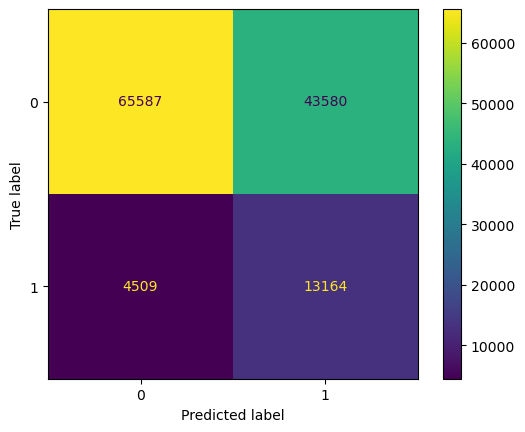

In [340]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=RF.classes_)
disp.plot()
plt.show()

In [341]:
CReport = classification_report(array_y_test, RF.predict(X_test_trans))

In [342]:
print(CReport)

              precision    recall  f1-score   support

           0       0.94      0.60      0.73    109167
           1       0.23      0.74      0.35     17673

    accuracy                           0.62    126840
   macro avg       0.58      0.67      0.54    126840
weighted avg       0.84      0.62      0.68    126840



Our recall is 74% or True Positives/(True Positives + False Positives).
In the above confusion matrix this would be 13164/(13164 + 4509). This implies 74% of the time we can identify all cases
of the target class while actually predicting the target class or precision is 23%. Ouch!
Over all our model is only accurate 62% of the time. This is a non functional model. Social indicators are not
enough to predict diabetes. We need more indicative features. We can try to improve statistics by hyper turning via grid search.

### Grid Search & Hyperparamater Tuning

In [360]:
# We can try different parameters in Random Forest using a grid search 
# n_estimators
# max_features (sqrt(n_features))
max_feat = int(X_train_trans.shape[1]**.5)

param_grid = {'n_estimators':[25,50,75,100,250],
             'max_features': [max_feat, max_feat - 1, max_feat-2]
             }

In [361]:
# Build the new model
RF2 = RandomForestClassifier(n_jobs = -1,class_weight='balanced')
grid_search = GridSearchCV(RF2, param_grid, cv = 5, return_train_score=True)
grid_search.fit(X_train_trans,array_y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1),
             param_grid={'max_features': [5, 4, 3],
                         'n_estimators': [25, 50, 75, 100, 250]},
             return_train_score=True)

In [371]:
print(grid_search.score(X_test_trans, array_y_test))
print(grid_search.best_score_ ,'\n', grid_search.best_params_)
print(grid_search.best_estimator_)

0.6188820561337117
0.6247161778618733 
 {'max_features': 3, 'n_estimators': 50}
RandomForestClassifier(class_weight='balanced', max_features=3, n_estimators=50,
                       n_jobs=-1)


Our accuracy did not improve a lot and our model was trained with max_features of 3 and n_estimators 50. Let us generate
another classification report. 

In [364]:
CReport2 = classification_report(array_y_test, grid_search.predict(X_test_trans))
print(CReport2) 

              precision    recall  f1-score   support

           0       0.94      0.60      0.73    109167
           1       0.23      0.75      0.35     17673

    accuracy                           0.62    126840
   macro avg       0.58      0.67      0.54    126840
weighted avg       0.84      0.62      0.68    126840



Overall, the recall did improve and the accuracy stayed around ~ 62%. This model would not go into production as more 
substantial variables are needed to predict diabetes. Follow up might also include utilizing another ensemble model such as gradient boosting or xgboost to help train weak learners. Furthermore, it would be beneficial to experiement with thresholding depending on business needs or taking advantage of up/down/smote sampling via cross validation. 